# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, MaxPooling1D, Activation, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

2024-03-20 11:15:04.627191: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 11:15:04.694132: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 11:15:05.012330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 11:15:05.012387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 11:15:05.070653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Análise e visualização de ativos

### Carrega Dados

In [3]:
yfin.pdr_override()

acoes=['B3SA3','PETR4','KLBN11']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['B3SA3.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-01 -> 2024-03-20)')



[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PETR4.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-01 -> 2024-03-20)')



[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KLBN11.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-01 -> 2024-03-20)')



[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['^BVSP']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-01 -> 2024-03-20)')


(0, 4)

In [4]:
sns.heatmap(acoes_df.isnull())

ValueError: zero-size array to reduction operation fmin which has no identity

In [ ]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,3.250000,15.470000,11.744000,48321.0
2014-01-24,3.233333,15.100000,11.744000,47787.0
2014-01-27,3.300000,15.110000,11.744000,47701.0
2014-01-28,3.280000,15.050000,12.586000,47841.0
2014-01-29,3.170000,14.800000,12.350000,47557.0
...,...,...,...,...
2024-03-06,12.250000,40.840000,22.150000,128890.0
2024-03-07,12.320000,40.389999,22.370001,128340.0
2024-03-08,12.460000,36.700001,22.040001,127071.0


### Visualização dos dados 

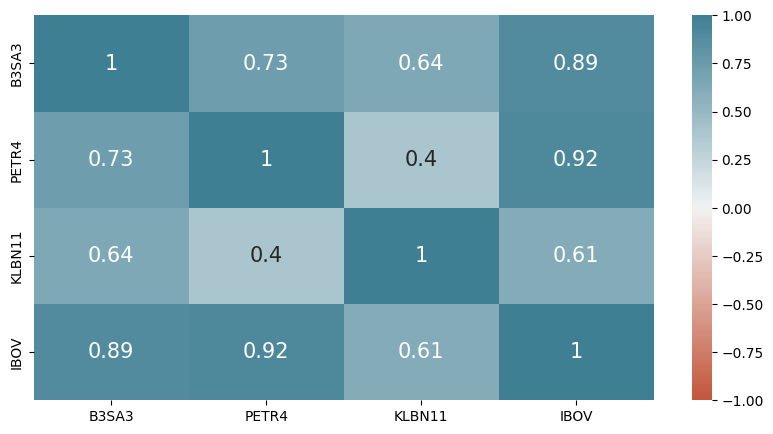

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [ ]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [ ]:
acoes_df_normalized

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,1.000000,1.000000,1.000000,1.000000
2014-01-24,0.994872,0.976083,1.000000,0.988949
2014-01-27,1.015385,0.976729,1.000000,0.987169
2014-01-28,1.009231,0.972851,1.071696,0.990066
2014-01-29,0.975385,0.956690,1.051601,0.984189
...,...,...,...,...
2024-03-06,3.769231,2.639948,1.886069,2.667370
2024-03-07,3.790769,2.610860,1.904802,2.655988
2024-03-08,3.833846,2.372334,1.876703,2.629726


In [ ]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [ ]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [ ]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for acoes in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[acoes], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [ ]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [ ]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP"
ticker = "B3SA3"


if ticker!="^BVSP":
    ticker=ticker+".SA"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')



[*********************100%%**********************]  1 of 1 completed


In [ ]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [ ]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111*2'], mode='lines', name='MA111*2'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350*2'], mode='lines', name='MA350*2'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [ ]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [ ]:

# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variation'] = ((df['Close'] - df['Close'].shift(+1)) / df['Close'])*100
#pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100


# Thresholds for variation classification
positive_threshold = 0.03
negative_threshold = -0.03

# Create a new column for classified variation
df['Classification'] = df['Variation'].apply(lambda x: 
                                            1 if x > positive_threshold else (
                                                -1 if x < negative_threshold else 0))

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df


,Date,Open,High,Low,Close,Adj Close,Volume,upper_band_bollinger,lower_band_bollinger,EMA9,...,MA350*2,RSI_14,MACD,Signal,Variation,Classification,weekday,day,month,quarter
0,2015-01-02,3.270000,3.270000,3.150000,3.170000,2.279343,21734100,0.000000,0.000000,3.170000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,5,2,1,1
1,2015-01-05,3.143333,3.153333,3.056666,3.083333,2.217027,34790100,0.000000,0.000000,3.121852,...,0.000000,0.000000,-0.006914,-0.001383,-2.810824,-1,1,5,1,1
2,2015-01-06,3.066666,3.113333,3.033333,3.113333,2.238597,49214700,0.000000,0.000000,3.118360,...,0.000000,0.000000,-0.009858,-0.003078,0.963597,1,2,6,1,1
3,2015-01-07,3.133333,3.283333,3.126666,3.236666,2.327279,24006600,0.000000,0.000000,3.158437,...,0.000000,0.000000,-0.002215,-0.002905,3.810494,1,3,7,1,1
4,2015-01-08,3.296666,3.300000,3.190000,3.193333,2.296121,22967700,0.000000,0.000000,3.168818,...,0.000000,0.000000,0.000343,-0.002256,-1.356985,-1,4,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,2024-03-06,12.280000,12.360000,12.140000,12.250000,12.250000,64366000,13.416493,12.049507,12.458388,...,25.900171,40.178584,-0.284121,-0.261560,0.489799,1,3,6,3,1
2281,2024-03-07,12.240000,12.400000,12.110000,12.320000,12.320000,43360500,13.356955,12.020044,12.430710,...,25.886000,40.969168,-0.279791,-0.265206,0.568179,1,4,7,3,1
2282,2024-03-08,12.230000,12.570000,12.180000,12.460000,12.460000,62540000,13.216340,12.063659,12.436568,...,25.872400,45.147691,-0.262041,-0.264573,1.123598,1,5,8,3,1
2283,2024-03-11,12.360000,12.720000,12.360000,12.580000,12.580000,34745900,13.132976,12.089024,12.465254,...,25.862286,41.964296,-0.235576,-0.258774,0.953894,1,1,11,3,1


## Data preprocessing to stock forecast

### Pré-processamento dos dados para predição 

In [ ]:
ticker

'B3SA3.SA'

In [ ]:
# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
#ticker='IBOV'
if 'SA' in ticker:
    ticker=ticker[:-3]
    
acoes_df = acoes_df[['Date', ticker]]
acoes_df.columns = ['ds', 'y']

In [ ]:
# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

In [ ]:
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']
acoes_df = df[['Close']+features_indicators]  
acoes_df_normalized = acoes_df / acoes_df.max().values
acoes_df_normalized.describe()
acoes_df['ds']=df['Date']

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20444\925237688.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
[feature.split('_') for feature in features_indicators]

[['EMA9'],
 ['EMA20'],
 ['EMA50'],
 ['EMA100'],
 ['EMA200'],
 ['RSI', '14'],
 ['MACD'],
 ['upper', 'band', 'bollinger'],
 ['lower', 'band', 'bollinger']]

In [ ]:
def comput_features(data_array, lookback = 1, features_indicators=[]):
    """_summary_

    Args:
        data_array (_type_): transformed dat in scaler 
        lookback (int, optional): _description_. Defaults to 1.
        features_indicators (list, optional): _description_. Defaults to [].

    Returns:
        _type_: _description_
    """
    #df_=pd.DataFrame(data=scaler.inverse_transform(data_array.reshape(-1,1)),columns=['Close'])
    df_=pd.DataFrame(data=data_array.reshape(-1,1),columns=['Close'])


    if  True in ['bollinger' in feature.split('_') for feature in features_indicators]:
        df_['upper_band_bollinger'],df_['lower_band_bollinger']=calculate_bollinger_bands(df_)
    # Calcula as EMAs de 9 e 20 períodos
    if 'EMA9' in features_indicators:
        df_['EMA9'] = df_['Close'].ewm(span=9).mean()
    if 'EMA20' in features_indicators:   
        df_['EMA20'] = df_['Close'].ewm(span=20).mean()
    if 'EMA50' in features_indicators: 
        df_['EMA50'] = df_['Close'].ewm(span=50).mean()
    if 'EMA100' in features_indicators: 
        df_['EMA100'] = df_['Close'].ewm(span=100).mean()
    if 'EMA200' in features_indicators: 
        df_['EMA200'] = df_['Close'].ewm(span=200).mean()
    if 'MA111' in features_indicators: 
        df_['MA111'] = df_['Close'].rolling(window=111).mean()
    if 'MA350' in features_indicators: 
        df_['MA350'] = df_['Close'].rolling(window=350).mean() 
    if 'RSI_14' in features_indicators: 
        # Calculate RSI (14-period)
        df_['RSI_14'] = calculate_rsi(df, window=14)
    if 'MACD' in features_indicators: 
        # Calculate MACD (12, 26, 9)
        df_['MACD'], df_['Signal'] = calculate_macd(df_, short_window=12, long_window=26, signal_window=9)
    
    df_.iloc[:]= np.nan_to_num(df_.values)
    
    #return  df_[['Close']+features_indicators].iloc[-lookback:,:].values.reshape(1,-1)
    X_features=np.concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1)

    #for columns in df_.columns:
    #    df_[columns]= scaler.transform(df_[columns].values.reshape(-1,1))
    #X_features=scaler.transformnp(concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1))
    return X_features

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'MA111', 'MA350',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200']
                     #'MA111', 'MA350',
                     #'MACD','upper_band_bollinger', 'lower_band_bollinger']
#df.loc[:,['Close']+features_indicators]=df_.loc[:,['Close']+features_indicators]
#features_indicators=[]

In [ ]:
df_norm=df.copy()
df_norm['Close']=scaler.transform(df['Close'].values.reshape(-1,1))

In [ ]:
#lookback = 23  # number of past days used to predict the future value
lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data, features_indicators):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        #X += [data[['Close']+features_indicators].values[win-lookback:win]]
        X_inputs=comput_features(data['Close'].values[:win],lookback, features_indicators).reshape(1,-1)
        X +=[X_inputs]
        #X +=[np.concatenate([data['Close'].values[win-lookback:win],data[features_indicators].values[win]])]
        #X +=[data['Close'].values[win-lookback:win]]
        y += [data[['Close']].values[win:win+pred_days]]
    


    data['Variation'] = ((data['Close'] - data['Close'].shift(+1)) / data['Close'])*100
    #pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

    # Thresholds for variation classification
    positive_threshold = 0.03
    negative_threshold = -0.03

    # Create a new column for classified variation
    data['buy'] = data['Variation'].apply(lambda x: 1 if x > positive_threshold else 0)
    data['sell'] = data['Variation'].apply(lambda x: 1 if x < negative_threshold else 0)
    data['wait'] = data['Variation'].apply(lambda x: 1 if (x > negative_threshold and x<positive_threshold) else 0)

    #y_classification = np.vstack(data['Classification'].astype('float32')[lookback:])
    y_classification = data[['wait','buy','sell']].values

    X=np.array(X)
    X=np.nan_to_num(np.vstack(X.T).T)
    y_regression=np.vstack(y)
    return X, [y_regression, y_classification]

X, y = windowing(df_norm,features_indicators)
date_time=df_norm['Date'][lookback:]

#date_time =date_time_old + datetime.timedelta(days=pred_days)
#from tensorflow.keras.utils import to_categorical

#y[1]=to_categorical(y[1])

print("X shape",X.shape)
print("y regression shape",y[0].shape)
print("y classification shape",y[1].shape)
print("Last Date",date_time.values[-1])

X shape (2262, 28)
y regression shape (2262, 1)
y classification shape (2285, 3)
Last Date 2024-03-12T00:00:00.000000000


In [ ]:
#y=scaler.transform(y)
#for idx in range(len(features_indicators)+ lookback):
#    X[:,idx]=np.squeeze(scaler.transform(X[:,idx].reshape(-1,1)))

In [ ]:
features_indicators

['EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200']

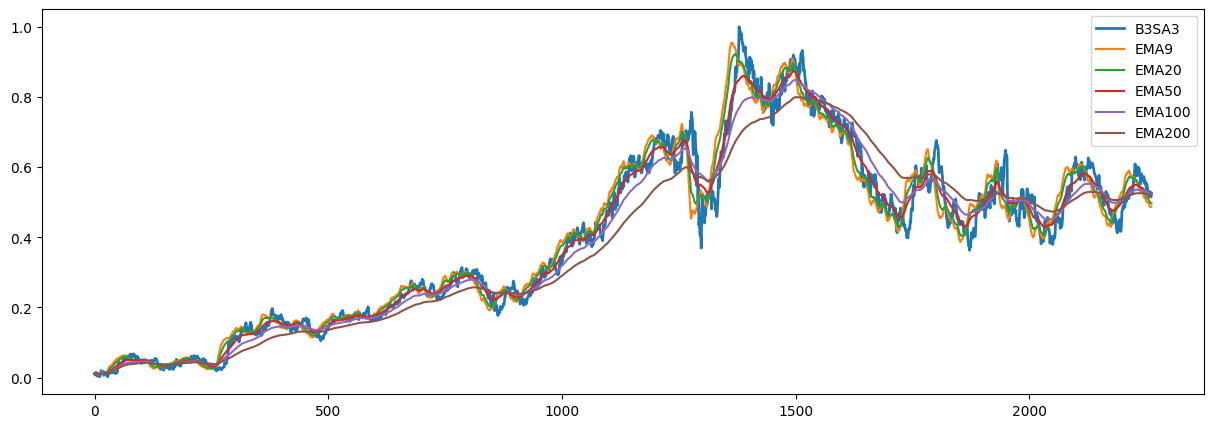

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(X[:,0],label=ticker,linewidth=2)
plt.plot(X[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [ ]:
# separa os dados em Treino e Teste
def split_data(X : np.array ,y : np.array, date_time : np.datetime64,factor=0.70):
    """Split the data in train validation or test

    Args:
        X (np.array): _description_
        y (np.array): _description_
        date_time (np.datetime64): _description_
        factor (float, optional): _description_. Defaults to 0.70.

    Returns:
        _type_: _description_
    """
    nits=round(len(X)*factor)

    X_train=X[:nits,:]

    nit_test= np.max(X_train.shape) -1
    X_test = X[nit_test:,:]

    y_train = []
    y_test =[]
    for idx in range(len(y)):
        y_train +=[y[idx][:nits]]
        y_test += [y[idx][nit_test:]]

    T_train = date_time[:nits]
    T_test = date_time[nit_test:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.85)

In [ ]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train ,y=np.squeeze(y_train[0]), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.squeeze(y_test[0]), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)
fig.show()

## Neural Networkt aproach

### Used Models

#### CNN_LSTM

In [ ]:
n_classes=y[1].shape[1]

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.models import Model

# Model name
model_name = "CNN_LSTM_MultiHead"
np.random.seed(42)

# Define CNN-LSTM feature extraction function
def CNN_LSTM(inputs):
  x = Conv1D(64, kernel_size=3, strides=1, activation='relu')(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling1D(2)(x)
  x = Dropout(0.2)(x)
  return x

def CNN_bracnh(Features):
    x = Conv1D(164, kernel_size=3, strides=1, activation='relu')(Features)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x
  
# Define a single function for both heads (regression and classification)
def head(features, n_outputs, activation, name= None):
  x = Dense(32)(features)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  output = Dense(n_outputs)(x)

  output = Activation(activation, name=name)(output)  # Dynamic output name

  return output

# Create the full model
input_shape = (X.shape[1], 1)  # Assuming your input shape
input_data = Input(shape=input_shape)

Features = CNN_LSTM(input_data)
features_branch1=CNN_bracnh(Features)
features_branch2=CNN_bracnh(Features)
# Create separate heads with appropriate number of outputs and activations
regression_output = head(features_branch1, n_outputs=pred_days, activation='linear',name='regression_head')
classification_output = head(features_branch2, n_outputs=n_classes, activation='sigmoid',name='classification_head')

# Create the model with two heads
model_CNN_LSTM = Model(inputs=input_data, outputs=[regression_output, classification_output])
model_CNN_LSTM._name = model_name

# Print model summary
model_CNN_LSTM.summary()

Model: "CNN_LSTM_MultiHead"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 28, 1)]              0         []                            
                                                                                                  
 conv1d_7 (Conv1D)           (None, 26, 64)               256       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_20 (Ba  (None, 26, 64)               256       ['conv1d_7[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_7 (MaxPoolin  (None, 13, 64)               0         ['batch_norma

In [ ]:
# Model name
model_name = "CNN_MultiHead"
np.random.seed(42)

def common_layers(input1):
        """Common layers to the network model

        Returns:
            Graph: the common layers model
        """

        ##################################################################
        # CNN architecture
        conv_layer = Conv1D(64, (3), padding="same")(input1)
        #conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)
        conv_layer = MaxPooling1D(pool_size=(3), strides=1, padding="same")(conv_layer)
        conv_layer = Conv1D(128, (3), padding="same")(conv_layer)
        #conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)
        conv_layer = MaxPooling1D(pool_size=(3), strides=2, padding="same")(conv_layer)
        
        ##################################################################

        return conv_layer

def head_layer(conv_layer, num_classes, activation='linear', output_name=None):
    
    head1 = Conv1D(64, (3), padding="same")(conv_layer)
    #head1 = BatchNormalization()(head1)
    head1 = Activation('relu')(head1)
    head1 = MaxPooling1D(pool_size=(3), strides=2, padding="same")(head1)

    head1 = Dropout(0.5)(head1)
    head1 = Flatten()(head1)

    x = Dense(32)(head1)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(256)(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(num_classes)(x)
    x = Activation(activation, name=output_name)(x)

    return x

# Create the full model
input_shape = (X.shape[1], 1)  # Assuming your input shape
input_data = Input(shape=input_shape)

Features = common_layers(input_data)
# Create separate heads with appropriate number of outputs and activations
regression_output = head_layer(Features, num_classes=pred_days, activation='linear',output_name='regression_head')
classification_output = head_layer(Features, num_classes=n_classes, activation='softmax',output_name='classification_head')

# Create the model with two heads
model_CNN_MultiHead = Model(inputs=input_data, outputs=[regression_output, classification_output])
model_CNN_MultiHead._name = model_name

# Print model summary
model_CNN_MultiHead.summary()

Model: "CNN_MultiHead"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 28, 1)]              0         []                            
                                                                                                  
 conv1d_10 (Conv1D)          (None, 28, 64)               256       ['input_8[0][0]']             
                                                                                                  
 activation_19 (Activation)  (None, 28, 64)               0         ['conv1d_10[0][0]']           
                                                                                                  
 max_pooling1d_10 (MaxPooli  (None, 28, 64)               0         ['activation_19[0][0]']       
 ng1D)                                                                                

#### MultiLayer Perceptron

In [ ]:
# Model name
model_name = "MLP"

# Input layer
input_data = Input(shape=(X.shape[1],))

# Dense layer 1 with batch normalization
dense1 = Dense(256)(input_data)
bn1 = BatchNormalization()(dense1)
activation1 = Activation('relu')(bn1)

# Dense layer 2 with batch normalization and dropout
dense2 = Dense(128)(activation1)
bn2 = BatchNormalization()(dense2)
activation2 = Activation('relu')(bn2)
dropout2 = Dropout(0.2)(activation2)


# Define a single function for both heads (regression and classification)
def head(features, n_outputs, activation='linear', name= None):
  """
  Defines a dense layer head for either regression or classification.

  Args:
      features: Input tensor from the feature extraction part.
      n_outputs: Number of outputs for the head.
      activation: Activation function for the output layer (defaults to 'linear' for regression).

  Returns:
      A Keras functional API model representing the head with its output.
  """

  x = Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros')(features)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  output = Dense(n_outputs)(x)

  output = Activation(activation, name=name)(output)  # Dynamic output name

  return output

# Create separate heads with appropriate number of outputs and activations
regression_output = head(dropout2, n_outputs=pred_days, activation='linear',name='regression_head')
classification_output = head(dropout2, n_outputs=n_classes, activation='softmax',name='classification_head')

# Create the model
model_MLP = Model(inputs=input_data, outputs=[regression_output, classification_output])
model_MLP._name = model_name

# Print model summary
model_MLP.summary()


Model: "MLP"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 28)]                 0         []                            
                                                                                                  
 dense_31 (Dense)            (None, 256)                  7424      ['input_9[0][0]']             
                                                                                                  
 batch_normalization_25 (Ba  (None, 256)                  1024      ['dense_31[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_27 (Activation)  (None, 256)                  0         ['batch_normalization_25[0][

#### Long Short-Term Memory (LSTM) 

In [ ]:
model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output  = LSTM(64, return_sequences=False)(input_data)
bn_lstm = BatchNormalization()(lstm_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 batch_normalization_29 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_31 (Activation)  (None, 64)                0         
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                              

#### Long Short-Term Memory (GRU) 

In [ ]:
model_name= "GRU"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
GRU_output  = GRU(64)(input_data)

bn_lstm = BatchNormalization()(GRU_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 1)]           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 batch_normalization_30 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_32 (Activation)  (None, 64)                0         
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                               

#### LSTM with Attention layer

In [ ]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [ ]:
model_name= "LSTM_AT"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

LSTM_output = tf.keras.layers.LSTM(64, return_sequences=True)(input_data)

bn_lstm = BatchNormalization()(LSTM_output)
activation_lstm = Activation('relu')(bn_lstm)
X = Dropout(0.2)(activation_lstm)

x = Attention(64)(X)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 28, 64)            16896     
                                                                 
 batch_normalization_31 (Ba  (None, 28, 64)            256       
 tchNormalization)                                               
                                                                 
 activation_33 (Activation)  (None, 28, 64)            0         
                                                                 
 dropout_25 (Dropout)        (None, 28, 64)            0         
                                                                 
 attention_1 (Attention)     (None, 64)                4225      
                                                           

### Hyperparams and trainnig

**Metrics and Loss Functions**  

In [ ]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [ ]:
def get_optimizer():
    #optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    optimizer1 = tf.keras.optimizers.RMSprop(learning_rate=0.05)
    return optimizer1
    #

**Train options callbacks**  

In [ ]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

### Models train

In [ ]:
categorical_accuracy =tf.keras.metrics.categorical_accuracy

In [ ]:
y_train.shape

AttributeError: 'list' object has no attribute 'shape'

Training model : models/model_MLP_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200


84/85 [============================>.] - ETA: 0s - loss: 1.0545 - regression_head_loss: 0.1856 - classification_head_loss: 0.8689 - regression_head_NRMSE: 0.7350 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5663 - classification_head_categorical_accuracy: 0.4792
Epoch 1: val_loss improved from inf to 4.50767, saving model to models\model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 8s 55ms/step - loss: 1.0541 - regression_head_loss: 0.1854 - classification_head_loss: 0.8687 - regression_head_NRMSE: 0.7378 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5664 - classification_head_categorical_accuracy: 0.4792 - val_loss: 4.5077 - val_regression_head_loss: 3.6503 - val_classification_head_loss: 0.8573 - val_regression_head_NRMSE: -0.8027 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5762 - val_classification_head_categorical_accuracy: 0.4593 - lr: 0.0500
Epoch 2/200
80/85 [===========================>..] - ETA: 0s - loss: 0.8069 - regression_head_loss: 0.0126 - classification_head_loss: 0.7944 - regression_head_NRMSE: 0.9052 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5813 - classification_head_categorical_accuracy: 0.5078
Epoch 2: val_loss improved from 4.50767 to 0.86186, saving model to models\model_MLP_stock_B3SA3_lookb

INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 4s 48ms/step - loss: 0.8063 - regression_head_loss: 0.0124 - classification_head_loss: 0.7938 - regression_head_NRMSE: 0.9033 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5825 - classification_head_categorical_accuracy: 0.5104 - val_loss: 0.8619 - val_regression_head_loss: 0.0105 - val_classification_head_loss: 0.8514 - val_regression_head_NRMSE: 0.9131 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5683 - val_classification_head_categorical_accuracy: 0.5234 - lr: 0.0500
Epoch 3/200
82/85 [===========================>..] - ETA: 0s - loss: 0.8183 - regression_head_loss: 0.0108 - classification_head_loss: 0.8076 - regression_head_NRMSE: 0.9088 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5781 - classification_head_categorical_accuracy: 0.4809
Epoch 3: val_loss did not improve from 0.86186
85/85 [==============================] - 1s 10ms/step - 

INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 4s 43ms/step - loss: 0.8017 - regression_head_loss: 0.0089 - classification_head_loss: 0.7928 - regression_head_NRMSE: 0.9139 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5820 - classification_head_categorical_accuracy: 0.4970 - val_loss: 0.8211 - val_regression_head_loss: 0.0348 - val_classification_head_loss: 0.7863 - val_regression_head_NRMSE: 0.8162 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5848 - val_classification_head_categorical_accuracy: 0.5234 - lr: 0.0500
Epoch 7/200
82/85 [===========================>..] - ETA: 0s - loss: 0.7999 - regression_head_loss: 0.0092 - classification_head_loss: 0.7907 - regression_head_NRMSE: 0.9132 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5814 - classification_head_categorical_accuracy: 0.4924
Epoch 7: val_loss did not improve from 0.82109
85/85 [==============================] - 1s 14ms/step - 

INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 3s 42ms/step - loss: 0.7975 - regression_head_loss: 0.0083 - classification_head_loss: 0.7892 - regression_head_NRMSE: 0.9177 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5818 - classification_head_categorical_accuracy: 0.4889 - val_loss: 0.7726 - val_regression_head_loss: 0.0053 - val_classification_head_loss: 0.7672 - val_regression_head_NRMSE: 0.9354 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5868 - val_classification_head_categorical_accuracy: 0.5234 - lr: 0.0500
Epoch 9/200
82/85 [===========================>..] - ETA: 0s - loss: 0.7978 - regression_head_loss: 0.0077 - classification_head_loss: 0.7901 - regression_head_NRMSE: 0.9208 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5817 - classification_head_categorical_accuracy: 0.4970
Epoch 9: val_loss did not improve from 0.77256
85/85 [==============================] - 1s 7ms/step - l

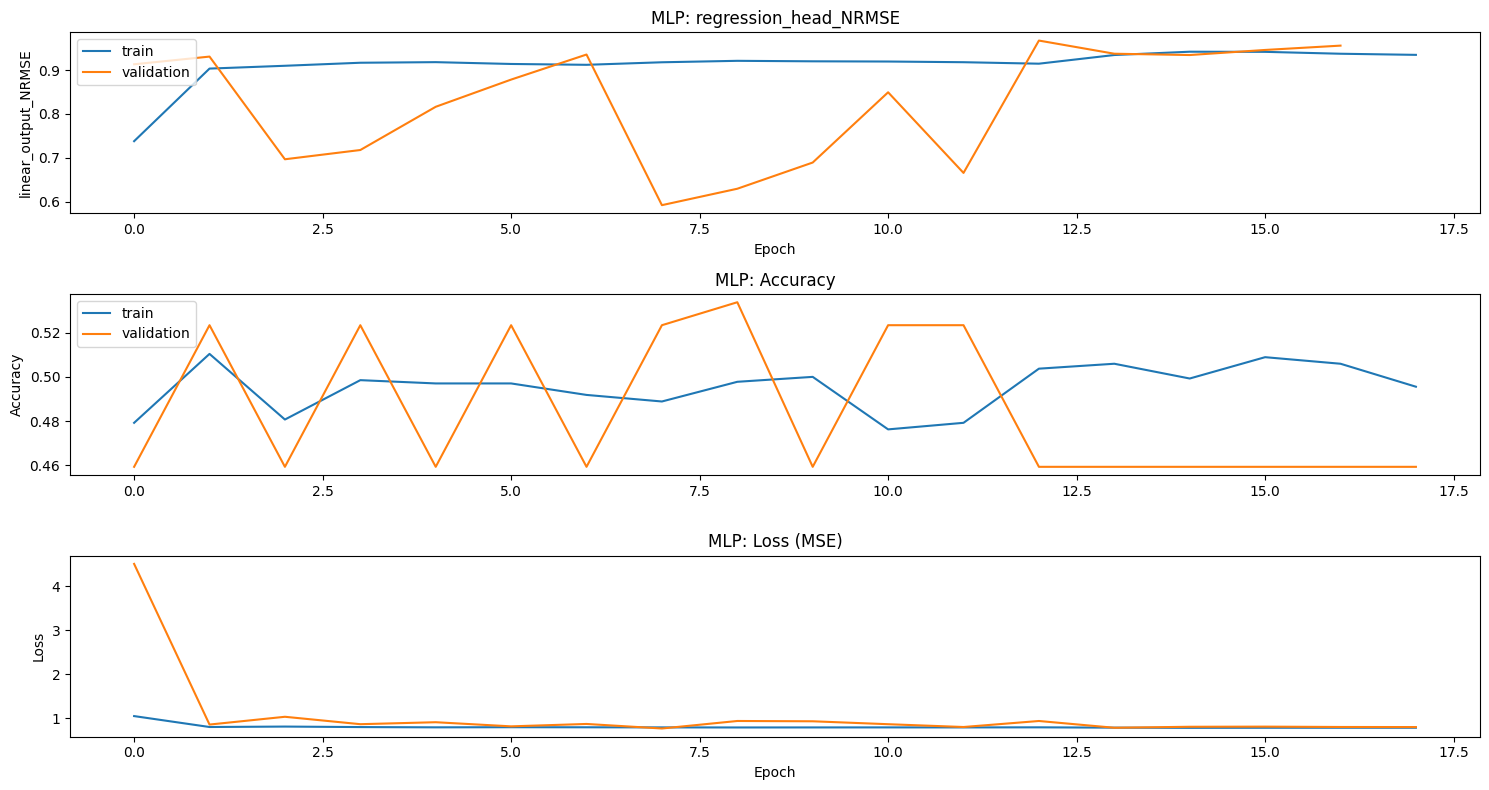

Training model : models/model_CNN_LSTM_MultiHead_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM_MultiHead
Epoch 1/200
83/85 [============================>.] - ETA: 0s - loss: 1.0003 - regression_head_loss: 0.1334 - classification_head_loss: 0.8669 - regression_head_NRMSE: 0.7580 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5228 - classification_head_categorical_accuracy: 0.4571
Epoch 1: val_loss improved from inf to 1.48521, saving model to models\model_CNN_LSTM_MultiHead_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_MultiHead_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_MultiHead_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 10s 66ms/step - loss: 0.9974 - regression_head_loss: 0.1318 - classification_head_loss: 0.8656 - regression_head_NRMSE: 0.7604 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5236 - classification_head_categorical_accuracy: 0.4599 - val_loss: 1.4852 - val_regression_head_loss: 0.6739 - val_classification_head_loss: 0.8113 - val_regression_head_NRMSE: 0.1821 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5498 - val_classification_head_categorical_accuracy: 0.5234 - lr: 0.0500
Epoch 2/200
84/85 [============================>.] - ETA: 0s - loss: 0.8183 - regression_head_loss: 0.0145 - classification_head_loss: 0.8037 - regression_head_NRMSE: 0.8916 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5505 - classification_head_categorical_accuracy: 0.5082
Epoch 2: val_loss improved from 1.48521 to 0.77406, saving model to models\model_CNN_LSTM_MultiHead_st

INFO:tensorflow:Assets written to: models\model_CNN_LSTM_MultiHead_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 5s 55ms/step - loss: 0.8182 - regression_head_loss: 0.0145 - classification_head_loss: 0.8036 - regression_head_NRMSE: 0.8923 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5507 - classification_head_categorical_accuracy: 0.5082 - val_loss: 0.7741 - val_regression_head_loss: 0.0065 - val_classification_head_loss: 0.7675 - val_regression_head_NRMSE: 0.9271 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5690 - val_classification_head_categorical_accuracy: 0.5113 - lr: 0.0500
Epoch 3/200
82/85 [===========================>..] - ETA: 0s - loss: 0.8113 - regression_head_loss: 0.0111 - classification_head_loss: 0.8001 - regression_head_NRMSE: 0.9103 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5612 - classification_head_categorical_accuracy: 0.4718
Epoch 3: val_loss did not improve from 0.77406
85/85 [==============================] - 1s 13ms/step - 

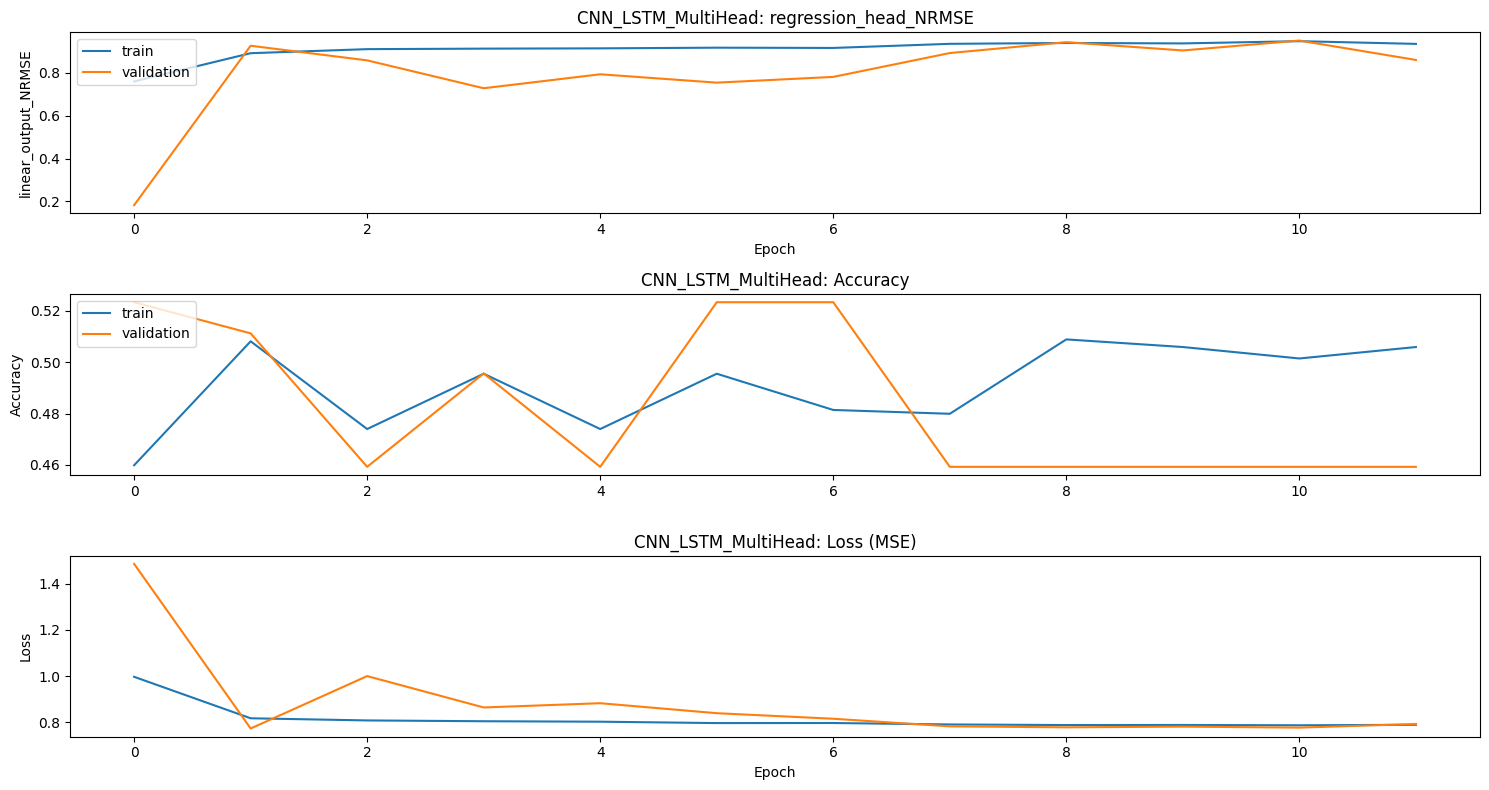

Training model : models/model_CNN_MultiHead_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_MultiHead
Epoch 1/200
84/85 [============================>.] - ETA: 0s - loss: 25897.0156 - regression_head_loss: 25887.8984 - classification_head_loss: 9.0569 - regression_head_NRMSE: -20.0461 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5627 - classification_head_categorical_accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.94562, saving model to models\model_CNN_MultiHead_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 8s 60ms/step - loss: 25858.5352 - regression_head_loss: 25849.4316 - classification_head_loss: 9.0445 - regression_head_NRMSE: -19.8007 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5629 - classification_head_categorical_accuracy: 0.4993 - val_loss: 0.9456 - val_regression_head_loss: 0.1590 - val_classification_head_loss: 0.7866 - val_regression_head_NRMSE: 0.6369 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5773 - val_classification_head_categorical_accuracy: 0.4593 - lr: 0.0500
Epoch 2/200
84/85 [============================>.] - ETA: 0s - loss: 0.8888 - regression_head_loss: 0.0487 - classification_head_loss: 0.8401 - regression_head_NRMSE: 0.7836 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5720 - classification_head_categorical_accuracy: 0.4918
Epoch 2: val_loss did not improve from 0.94562
85/85 [==============================] - 1s 13

INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 5s 61ms/step - loss: 0.8419 - regression_head_loss: 0.0416 - classification_head_loss: 0.8003 - regression_head_NRMSE: 0.7991 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5794 - classification_head_categorical_accuracy: 0.4785 - val_loss: 0.9235 - val_regression_head_loss: 0.1237 - val_classification_head_loss: 0.7998 - val_regression_head_NRMSE: 0.6889 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5719 - val_classification_head_categorical_accuracy: 0.4593 - lr: 0.0500
Epoch 4/200
81/85 [===========================>..] - ETA: 0s - loss: 0.8336 - regression_head_loss: 0.0409 - classification_head_loss: 0.7926 - regression_head_NRMSE: 0.8000 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5814 - classification_head_categorical_accuracy: 0.5054
Epoch 4: val_loss did not improve from 0.92348
85/85 [==============================] - 1s 18ms/step - 

INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 6s 67ms/step - loss: 0.8945 - regression_head_loss: 0.0414 - classification_head_loss: 0.8531 - regression_head_NRMSE: 0.7990 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5781 - classification_head_categorical_accuracy: 0.4963 - val_loss: 0.8762 - val_regression_head_loss: 0.0986 - val_classification_head_loss: 0.7776 - val_regression_head_NRMSE: 0.7315 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5810 - val_classification_head_categorical_accuracy: 0.4593 - lr: 0.0500
Epoch 9/200
85/85 [==============================] - ETA: 0s - loss: 0.8291 - regression_head_loss: 0.0417 - classification_head_loss: 0.7873 - regression_head_NRMSE: 0.7997 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5824 - classification_head_categorical_accuracy: 0.4955
Epoch 9: val_loss did not improve from 0.87617
85/85 [==============================] - 1s 16ms/step - 

INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 9s 110ms/step - loss: 0.8295 - regression_head_loss: 0.0411 - classification_head_loss: 0.7883 - regression_head_NRMSE: 0.7998 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5817 - classification_head_categorical_accuracy: 0.4866 - val_loss: 0.8632 - val_regression_head_loss: 0.0964 - val_classification_head_loss: 0.7668 - val_regression_head_NRMSE: 0.7356 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5865 - val_classification_head_categorical_accuracy: 0.5234 - lr: 0.0500
Epoch 14/200
82/85 [===========================>..] - ETA: 0s - loss: 0.8299 - regression_head_loss: 0.0420 - classification_head_loss: 0.7879 - regression_head_NRMSE: 0.7980 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5827 - classification_head_categorical_accuracy: 0.4962
Epoch 14: val_loss did not improve from 0.86318
85/85 [==============================] - 1s 11ms/step

INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 4s 50ms/step - loss: 0.8307 - regression_head_loss: 0.0414 - classification_head_loss: 0.7893 - regression_head_NRMSE: 0.7990 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5813 - classification_head_categorical_accuracy: 0.4911 - val_loss: 0.8611 - val_regression_head_loss: 0.0932 - val_classification_head_loss: 0.7679 - val_regression_head_NRMSE: 0.7415 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5862 - val_classification_head_categorical_accuracy: 0.5234 - lr: 0.0500
Epoch 16/200
82/85 [===========================>..] - ETA: 0s - loss: 0.8299 - regression_head_loss: 0.0414 - classification_head_loss: 0.7885 - regression_head_NRMSE: 0.7999 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5823 - classification_head_categorical_accuracy: 0.4848
Epoch 16: val_loss did not improve from 0.86111
85/85 [==============================] - 1s 14ms/step 

INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_B3SA3_lookback_23\assets


85/85 [==============================] - 12s 147ms/step - loss: 0.8307 - regression_head_loss: 0.0414 - classification_head_loss: 0.7893 - regression_head_NRMSE: 0.7980 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5817 - classification_head_categorical_accuracy: 0.4822 - val_loss: 0.8460 - val_regression_head_loss: 0.0751 - val_classification_head_loss: 0.7710 - val_regression_head_NRMSE: 0.7766 - val_regression_head_categorical_accuracy: 1.0000 - val_classification_head_NRMSE: 0.5840 - val_classification_head_categorical_accuracy: 0.4593 - lr: 0.0500
Epoch 19/200
79/85 [==========================>...] - ETA: 0s - loss: 0.8278 - regression_head_loss: 0.0416 - classification_head_loss: 0.7862 - regression_head_NRMSE: 0.7990 - regression_head_categorical_accuracy: 1.0000 - classification_head_NRMSE: 0.5821 - classification_head_categorical_accuracy: 0.4652
Epoch 19: val_loss did not improve from 0.84603
85/85 [==============================] - 1s 11ms/ste

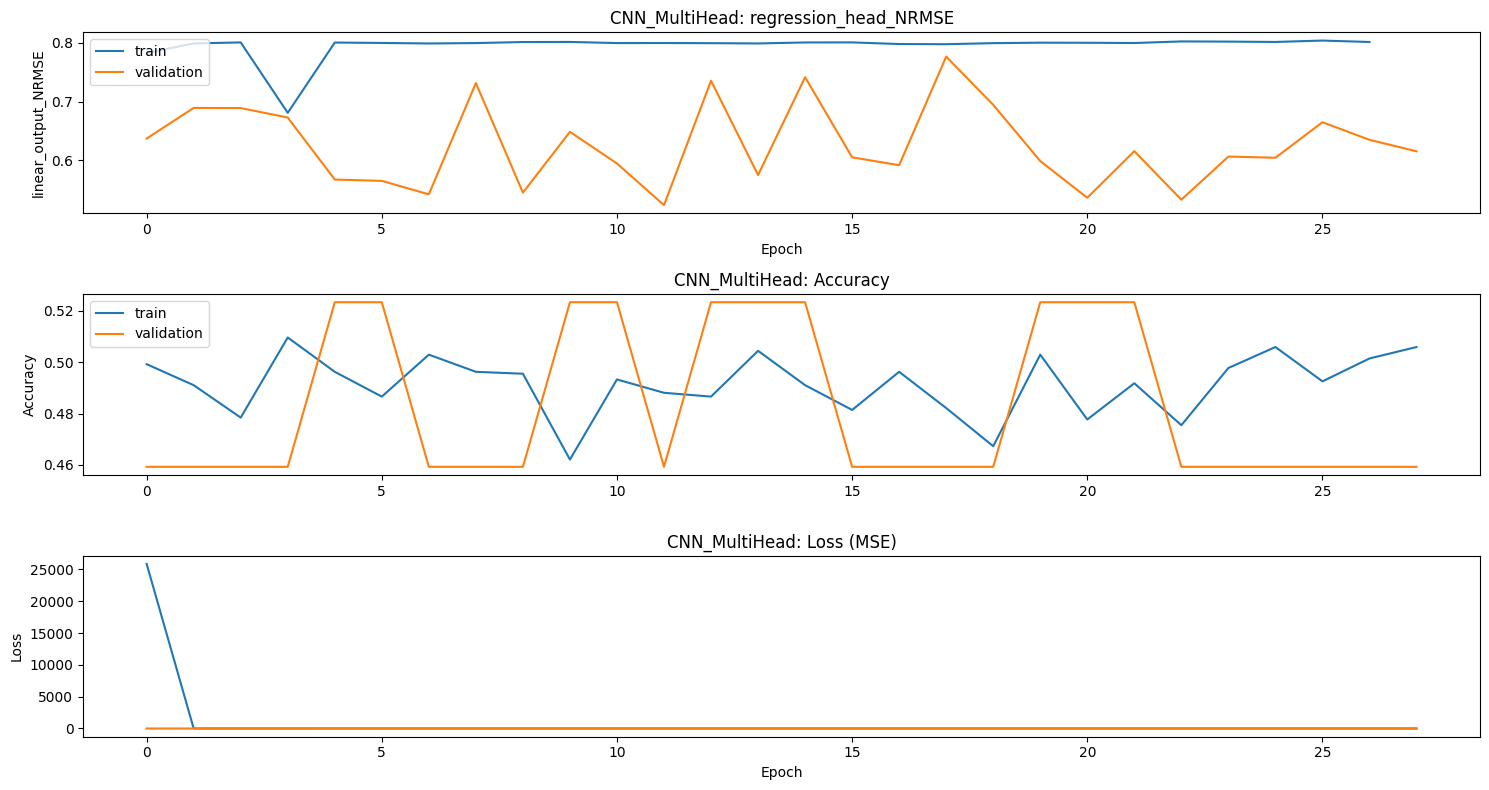

In [ ]:
#list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]
list_of_models=[model_MLP,model_CNN_LSTM,model_CNN_MultiHead]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss=['mean_squared_error','categorical_crossentropy'], optimizer=optimizer, metrics=[NRMSE, 'categorical_accuracy'])
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=16, shuffle=True, validation_split=0.3, callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])

    history_metric=np.array(history.history['regression_head_NRMSE']) 
    history_metric_val=np.array(history.history['val_regression_head_NRMSE'])  

    # Assuming history_metric, history_metric_val, history are defined elsewhere

    fig, axes = plt.subplots(3, 1, figsize=(15, 8))  # Create subplots programmatically

    # Plot NRMSE
    axes[0].plot(history_metric[history_metric > 0])
    axes[0].plot(history_metric_val[history_metric_val > 0])
    axes[0].set_title(f'{model._name}: regression_head_NRMSE')
    axes[0].set_ylabel('linear_output_NRMSE')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')

    # Plot accuracy, sharing x-axis with NRMSE
    axes[1].plot(history.history['classification_head_categorical_accuracy'])
    axes[1].plot(history.history['val_classification_head_categorical_accuracy'])
    axes[1].set_title(f'{model._name}: Accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[2].set_xlabel('Epoch')  # Shared x-axis label
    axes[1].legend(['train', 'validation'], loc='upper left')

    # Plot loss
    axes[2].plot(history.history['loss'])
    axes[2].plot(history.history['val_loss'])
    axes[2].set_title(f'{model._name}: Loss (MSE)')
    axes[2].set_ylabel('Loss')

    # Adjust spacing and margins (optional)
    plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.2)

    # Fine-tune spacing (optional)
    plt.tight_layout()

    plt.show()

    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

In [ ]:
'''from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier



kfold = KFold(n_splits=10, shuffle=True)

estimator = KerasClassifier(build_fn=model, epochs=200, batch_size=5, verbose=0)

results = cross_val_score(estimator, X, y[1], cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))'''

'from sklearn.model_selection import cross_val_score\nfrom sklearn.model_selection import KFold\nfrom keras.wrappers.scikit_learn import KerasClassifier\n\n\n\nkfold = KFold(n_splits=10, shuffle=True)\n\nestimator = KerasClassifier(build_fn=model, epochs=200, batch_size=5, verbose=0)\n\nresults = cross_val_score(estimator, X, y[1], cv=kfold)\nprint("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))'

### Validation

In [ ]:
# carrega os modelos terinados
from tensorflow import keras
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [ ]:
checkpoint_filepath

'models/model_CNN_MultiHead_stock_B3SA3_lookback_23'

In [ ]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x2ab2c492080>,
 'CNN_LSTM_MultiHead': <keras.src.engine.functional.Functional at 0x2ab24470550>,
 'CNN_MultiHead': <keras.src.engine.functional.Functional at 0x2ab2af03df0>}

In [ ]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(df,features_indicators)

for idx in range(len(features_indicators)+lookback):
    X_real[:,idx]=np.squeeze(scaler.transform(X_real[:,idx].reshape(-1,1)))
#X_real=features_scaler.transform(X_real)
#y_real=scaler.transform(y_real)
#X_real=features_scaler(X_real)

#do the smae split data with the original data to compare 
X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.85)

predictions=[]
for model_name in trained_best_models:
    y_regression,y_classification=trained_best_models[model_name].predict(X_test)
    y_pred=scaler.inverse_transform(y_regression)
    r2_score= R2(y_test_real[0], y_pred )
    print(model_name,'NN R2:', r2_score)

    predictions+=[y_pred]
predictions=np.hstack(predictions)

11/11 [==============================] - 0s 3ms/step
MLP NN R2: 0.4829649331521335
11/11 [==============================] - 0s 5ms/step
CNN_LSTM_MultiHead NN R2: -0.683976619350815
11/11 [==============================] - 0s 5ms/step
CNN_MultiHead NN R2: -1.7015491447638529


In [ ]:
def generate_data(X, y, model):
    y_pred =  np.argmax(model.predict(X_train)[1],axis=1)
    y_test =  np.argmax(y[1],axis=1)
    return y_test, y_pred
label_test,label_pred= generate_data(X_train, y_train, model)

61/61 [==============================] - 0s 4ms/step


In [ ]:
import utils
for model_name in trained_best_models:
    label_test,label_pred = generate_data(X_train, y_train, trained_best_models[model_name])
    print(model_name,' classification Accuracy',utils.accuracy_score(label_test,label_pred))
#utils.model_metrics(['subida','Descida'], y_test, y_pred, Get_metrics=False)
#utils.plot_confusion_matrix(['subida','Descida'], y_test, y_pred)

61/61 [==============================] - 1s 6ms/step
MLP  classification Accuracy 0.48673946957878317
61/61 [==============================] - 0s 5ms/step
CNN_LSTM_MultiHead  classification Accuracy 0.500260010400416
61/61 [==============================] - 0s 7ms/step
CNN_MultiHead  classification Accuracy 0.4919396775871035


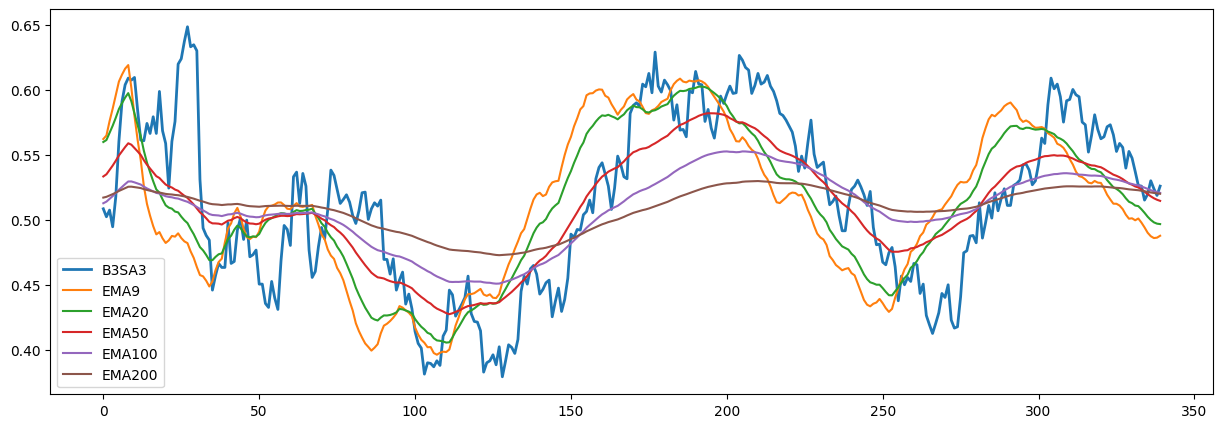

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(X_test[:,0],label=ticker,linewidth=2)
plt.plot(X_test[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [ ]:
y_test_real_regression=np.hstack(y_test_real[0])
y_pred=np.hstack(y_pred)
y_train_real_regression=np.hstack(y_train_real[0])

In [ ]:
trained_best_models.keys()

dict_keys(['MLP', 'CNN_LSTM_MultiHead', 'CNN_MultiHead'])

In [ ]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real_regression, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real_regression, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'yellow', 'violet', 'yellowgreen', 'green']
for i in range(predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_test, y=predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Get new values to future prediction 

In [ ]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-03-12
Estamos Fornecendo dados até o dia : 2024-03-11
O modelo fará previsões até o dia:  2024-03-18


In [ ]:
new_predictions=[]
y_pred_classification=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=1
    n_steps=5

    if dias_antes == 0:
        NN_predictions=y_test[0].copy()
        y_pred_head2=y_test[1].copy()
        # normalized data
        X_inputs=comput_features(scaler.transform(y_test_real_regression.reshape(-1,1)),lookback, features_indicators).reshape(1,-1)
        #X_inputs=X_test.copy()
        
        T_preds=T_test.values.copy()
    else :
        NN_predictions=y_test[0][:-dias_antes].copy()
        y_pred_head2=y_test[1][:-dias_antes].copy()
    
        X_inputs=comput_features(scaler.transform(y_test_real_regression.reshape(-1,1))[:-dias_antes,:],lookback, features_indicators).reshape(1,-1)

        #X_inputs=X_test[:-dias_antes,:].copy()
        T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    
    for k in range(n_steps):
        # normalzação das features
        #for idx in range(len(features_indicators)+lookback):
        #    X_inputs[-1,idx]=np.squeeze(scaler.transform(X_inputs[-1,idx].reshape(-1,1)))
        

        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))
        y_pred_head2 = np.append(y_pred_head2,y_pred[1],axis=0)
        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,comput_features(NN_predictions,lookback, features_indicators).reshape(1,-1),axis=0)

        
        #X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
    
    y_pred_classification +=[y_pred_head2]
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]

y_pred_classification=np.array(y_pred_classification)
new_predictions=np.hstack(new_predictions)

1/1 [==============================] - 0s 24ms/step


In [ ]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train[0],y_test[0][:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
    model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
    model_arima_fit = model_arima.fit()

    arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
    arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
    arima_predictions.shape

Using ARIMA model


In [ ]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real_regression, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [ ]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x2ab2c492080>,
 'CNN_LSTM_MultiHead': <keras.src.engine.functional.Functional at 0x2ab24470550>,
 'CNN_MultiHead': <keras.src.engine.functional.Functional at 0x2ab2af03df0>}

In [ ]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM_MultiHead')

pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': new_predictions[:,model_idx]})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.02 else 0)
pred_data_df['Subida_pred'] = np.argmax(y_pred_classification[model_idx],axis=1)
pred_data_df.tail(10)

ValueError: Length of values (367) does not match length of index (344)

In [ ]:
pred_data_df[pred_data_df['Data']==df['Date'].iloc[-1]]

,Data,pred,Variacao,Subida,Subida_pred
339,2024-03-11,13.284036,6.203206,1,1


In [ ]:
result=pred_data_df.iloc[-1:,:]
result

,Data,pred,Variacao,Subida,Subida_pred
343,2024-03-15,13.552655,0.64,1,1


In [ ]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )

A previsão para o dia 2024-03-15 é de subida, de 0.64% o valor predito é de: 13.55


In [ ]:
comput_features(y_test[0], lookback, features_indicators).reshape(1,-1)

array([[ 0.52594748,  0.53721414,  0.52338687,  0.52748383,  0.50802325,
         0.4993172 ,  0.50136568,  0.4993172 ,  0.51212021,  0.50546269,
         0.49726872,  0.48702633,  0.48856268,  0.50238995,  0.4936839 ,
         0.5064869 ,  0.48548998,  0.47934455,  0.47371119,  0.47678393,
         0.48036876,  0.48753846,  0.4936839 ,  0.48780755,  0.49677713,
         0.51462067,  0.52077532,  0.52018204,  0.51203718,  0.        ,
        -0.01206435,  0.52200291,  0.46854002]])

In [ ]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM_MultiHead')
model=list_of_models[model_idx]
X_features=comput_features(y_test[0], lookback, features_indicators).reshape(1,-1)
preds=model.predict(X_features)
scaler.inverse_transform(preds[0])

1/1 [==============================] - 1s 526ms/step


array([[13.245084]], dtype=float32)

In [ ]:
preds

[array([[0.5277442]], dtype=float32),
 array([[0.02031025, 0.9796897 ]], dtype=float32)]